In [7]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import
from __future__ import unicode_literals

import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline

In [8]:
sns.set()
sns.set_style("whitegrid")
sns.set_context("poster")

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'


# Introduction

The goal here is to test if the MNIST problem is separable and measur H-divergence

In [9]:
from problem.workflow import pprint

## Load data

In [2]:
from problem.mnist import load_data

In [3]:
print('Loading data ...')
X_orig, y = load_data()
print('Done !')

Loading data ...
Done !


## Skewing function

In [4]:
from problem.mnist import get_save_directory
from problem.mnist import skew
from problem.mnist import tangent
from problem.mnist import get_cv_iter


# Visualization




In [5]:
z = 5

## Difference

In [8]:
diff = X_orig - skew(X_orig, z)

### Changed columns

In [9]:
changed_cols = [c for c in diff if np.any( diff[c] != 0 )]
unchanged_cols = [c for c in diff if np.all( diff[c] == 0 )]

# Classification 

Here I measure the capacity of some classifier to separate between nominal data and skewed data.

If there is a data leakage, maybe some classfier will have very good performances on this task.

In [10]:
sns.set()
sns.set_style("whitegrid")
sns.set_context("poster")

mpl.rcParams['figure.figsize'] = [8.0*2, 6.0*2]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 30
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 30
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'


In [11]:
z = 5

## Build problem

I need 4 parts
0. the train unskewed
0. the train skewed
0. the test unskewed
0. the test skewed

In [12]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import check_cv
from sklearn.model_selection import train_test_split


In [13]:
def make_classification(X_orig, z):
    X_0, X_1 = train_test_split(X_orig, test_size=0.5)
    X_1 = skew(X_1, z)
    X = np.concatenate( [X_0, X_1] )
    y = np.concatenate( (np.zeros(X_0.shape[0]), np.ones(X_1.shape[0])) )
    return X, y


In [14]:
def cv_score(model, X, y, cv=ShuffleSplit(n_splits=3, test_size=0.2)):
    cv = check_cv(cv)
    train_scores = []
    test_scores = []
    for train_idx, test_idx in cv.split(X, y):
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_test = X[test_idx]
        y_test = y[test_idx]
        
        model.fit(X_train, y_train)
        
        sc = model.score(X_train, y_train)
        train_scores.append(sc)
        
        sc = model.score(X_test, y_test)
        test_scores.append(sc)
    
    return train_scores, test_scores


In [15]:
def test_all_z(model, X_orig, z_list=(0.95, 1.0, 1.05)):
    many_z = []
    train_scores = []
    test_scores = []
    
    for z in z_list:
        pprint( 'testing z = {} ...'.format(z) )
        X, y = make_classification(X_orig, z)
        cv = ShuffleSplit(n_splits=3, test_size=0.2)
        n_cv = cv.n_splits
        train_sc, test_sc = cv_score(model, X, y, cv=cv)
        
        pprint('test scores :', test_sc)
        many_z.extend([z]*n_cv)
        train_scores.extend(train_sc)
        test_scores.extend(test_sc)
    return many_z, train_scores, test_scores
        

## Neural net

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable

from models.net.minibatch import OneEpoch, EpochShuffle
from itertools import islice


In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x
    
    def reset_parameters(self):
        self.fc1.reset_parameters()
        self.fc2.reset_parameters()
        self.fc3.reset_parameters()
        self.bn1.reset_parameters()
        self.bn2.reset_parameters()


In [18]:

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

from models.net.neural_net import NeuralNetClassifier
from models.net.weighted_criterion import WeightedCrossEntropyLoss

from models.monitor import LossMonitorHook

class NeuralNetModel(BaseEstimator, ClassifierMixin):
    def __init__(self, n_steps=5000, batch_size=20, learning_rate=1e-3, cuda=False, verbose=0):
        super().__init__()
        self.n_steps = n_steps
        self.batch_size = batch_size
        self.cuda = cuda
        self.verbose = verbose
        
        self.net = Net()
        
        self.learning_rate = learning_rate
        self.optimizer = optim.Adam(self.net.parameters(), lr=learning_rate)
        self.criterion = WeightedCrossEntropyLoss()
        
        self.loss_hook = LossMonitorHook()
        self.criterion.register_forward_hook(self.loss_hook)
        
        self.clf = NeuralNetClassifier(self.net, self.criterion, self.optimizer, 
                                       n_steps=self.n_steps, batch_size=self.batch_size, cuda=cuda)

    def fit(self, X, y, sample_weight=None):
        X = X.reshape(-1, 28*28) / 255
        self.loss_hook.reset()
        self.clf.fit(X, y, sample_weight=sample_weight)
        return self
    
    def predict(self, X):
        X = X.reshape(-1, 28*28) / 255
        y_pred = self.clf.predict(X)
        return y_pred
    
    def predict_proba(self, X):
        X = X.reshape(-1, 28*28) / 255
        proba = self.clf.predict_proba(X)
        return proba


In [54]:
nn_clf = NeuralNetModel(learning_rate=1e-3, n_steps=15000)
z_list = [-10, -8, -5, -2, 0, 2, 5, 8, 10]

In [55]:
many_z, train_scores, test_scores = test_all_z(nn_clf, X_orig, z_list=z_list)

2018-04-19 16:41:45 testing z = -10 ...
2018-04-19 16:52:34 testing z = -8 ...
2018-04-19 17:01:25 testing z = -5 ...
2018-04-19 17:10:23 testing z = -2 ...
2018-04-19 17:18:07 testing z = 0 ...
2018-04-19 17:41:39 testing z = 2 ...


KeyboardInterrupt: 

In [ ]:
plt.plot(many_z, train_scores, 'o', label='train_scores')
plt.plot(many_z, test_scores, 'd', label='test_scores')
plt.title('Neural Net')
plt.xlabel('angle')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
plt.plot(nn_clf.loss_hook.losses)
plt.show()

# Regression

# $\chi^2$ test

In [19]:
from scipy.stats import chisquare
z = 1.03

## Neural network

In [45]:
model = NeuralNetModel(learning_rate=1e-3, batch_size=128, n_steps=15000, cuda=True)

X, y = make_classification(X_orig, z)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

### Training

In [46]:
model.fit(X_train, y_train)

NeuralNetModel(batch_size=128, cuda=True, learning_rate=0.001, n_steps=15000,
        verbose=0)

### Losses

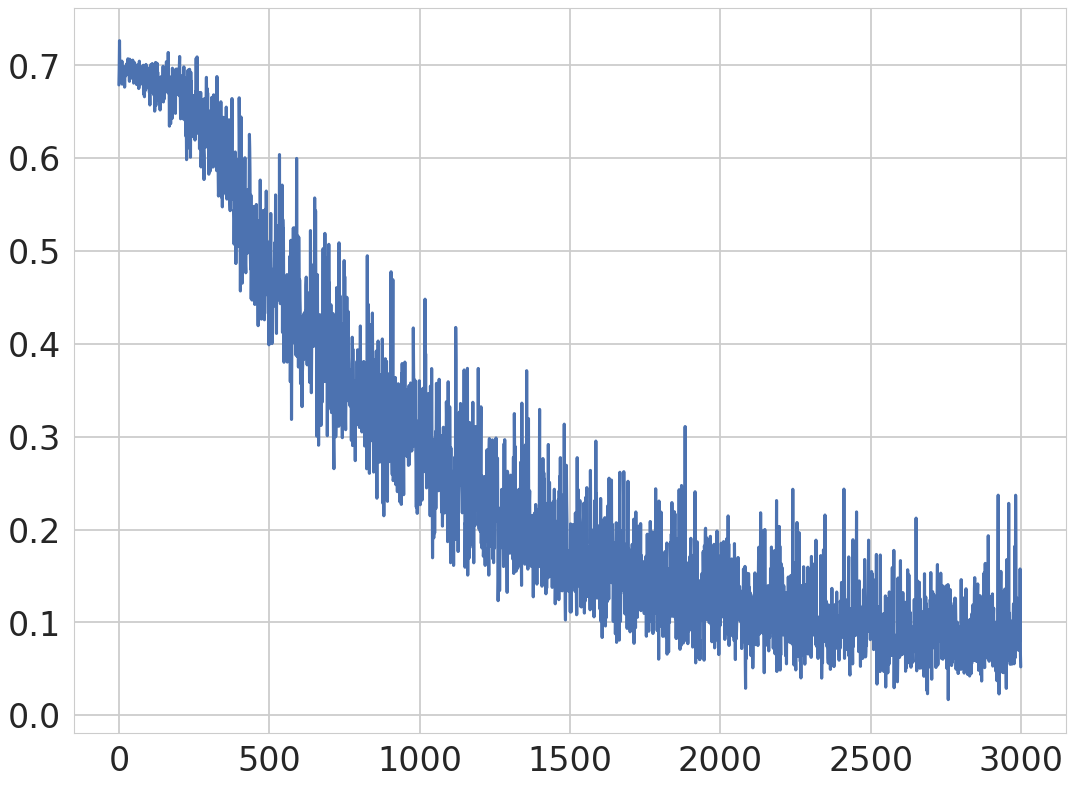

In [47]:
plt.plot(model.loss_hook.losses[::5])
plt.show()

### Prediction

In [48]:
proba = model.predict_proba(X_test)

threshold = 0.5

y_pred = np.asarray(proba[:, 1] > threshold, dtype=int)

score_nominal = proba[y_test==0, 1]
score_skewed = proba[y_test==1, 1]

### Score distribution

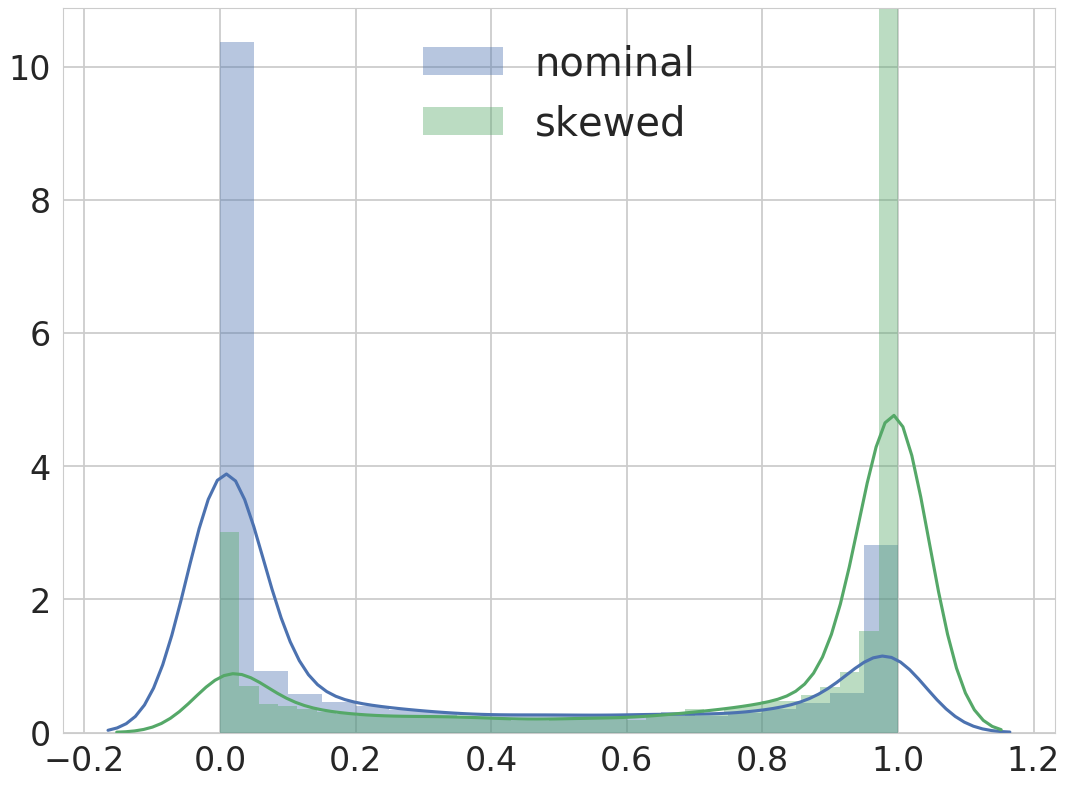

In [49]:
sns.distplot(score_nominal, label='nominal')
sns.distplot(score_skewed, label='skewed')

plt.legend()
plt.show()


### Confusion matrix

In [50]:
from sklearn.metrics import confusion_matrix
import itertools

12454 8711.5
5123 8711.5
3900 8711.5
13523 8711.5


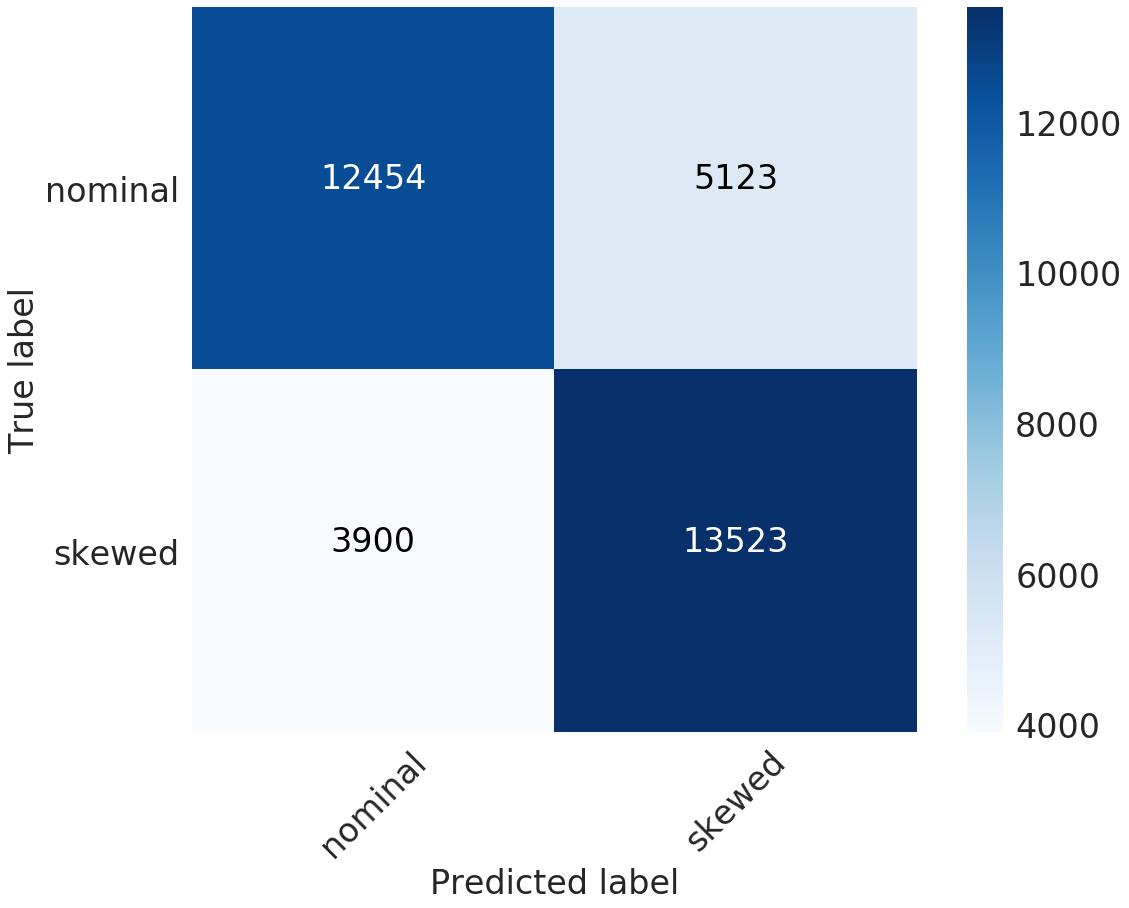

In [51]:
cm = confusion_matrix(y_test, y_pred)
with sns.axes_style('dark'):
    classes =  ['nominal', 'skewed']
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = (cm.max() + cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        print(cm[i, j], thresh)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.show()

### Chisquare

In [52]:
nominal_dist, bins = np.histogram(score_nominal, bins=35)
skewed_dist, _ = np.histogram(score_skewed, bins=bins)

print(chisquare(nominal_dist, skewed_dist))


Power_divergenceResult(statistic=40113.147065585086, pvalue=0.0)


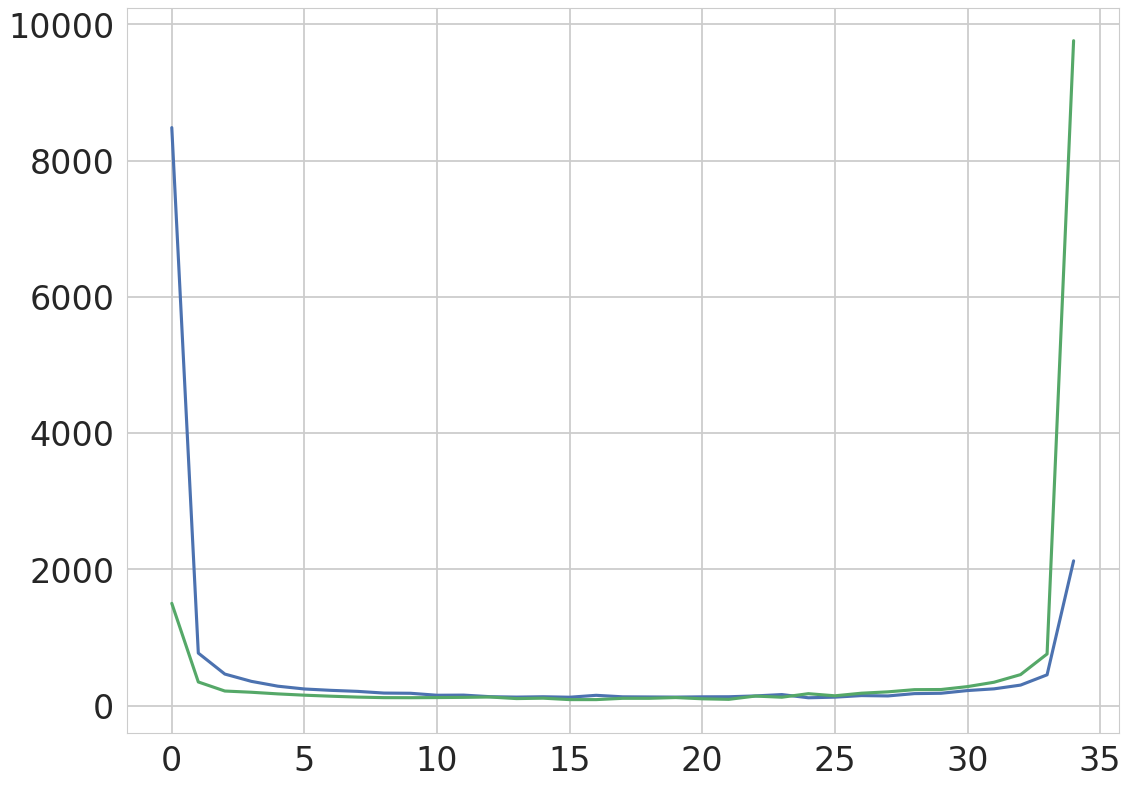

In [53]:
plt.plot(nominal_dist)
plt.plot(skewed_dist)
plt.show()
